To complete this assignment, submit a link to a Jupyter Notebook containing your solutions to the tasks outlined below. You can also take a look at these [example solutions](https://github.com/Thinkful-Ed/data-201-resources/blob/master/clustering_module_solutions/3.solution_evaluating_clusters.ipynb).

1. Get the silhouette coefficient of the two-cluster k-means solution. You'll notice that the silhouette coefficient will turn out to be greater than the one above, where the cluster number is three. You know that the iris dataset consists of three different clusters. So the silhouette score of the solution where the number of clusters is equal to the correct number of classes is actually lower than the silhouette score of the solution where the number of clusters is different from the correct number of classes. Can you explain why this is?
1. In this assignment, you'll continue working with the [heart disease dataset](http://archive.ics.uci.edu/ml/datasets/Heart+Disease) from the UC Irvine Machine Learning Repository.
> Load the dataset from Thinkful's database. To connect to the database, use these credentials:
```
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'
```
>The dataset needs some preprocessing. So, before working with the dataset, apply the following code:
```
 # Define the features and the outcome
 X = heartdisease_df.iloc[:, :13]
 y = heartdisease_df.iloc[:, 13]

 # Replace missing values (marked by `?`) with a `0`
 X = X.replace(to_replace='?', value=0)

 # Binarize `y` so that `1` means heart disease diagnosis and `0` means no diagnosis
 y = np.where(y > 0, 1, 0)
```
Here, `X` will represent your features and `y` will hold the labels. If `y` is equal to `1`, that indicates that the corresponding patient has heart disease. And if `y` is equal to `0`, then the patient doesn't have heart disease.

> 1. Split the data randomly into two. Apply k-means using two, three, and four as the number of clusters, as you did when you were exploring consistency earlier in this checkpoint. Assess the consistency of the solutions using visualization. Which one seems to be the best?
> 1. Apply k-means on the whole dataset by setting `k` equal to `2`, `3`, and `4`. Get the ARI score for each of them. Which model is best?
> 1. Apply k-means on the whole dataset by setting `k` equal to `2`, `3`, and `4`. Get the silhouette coefficient for each of them. Which model is best?

# Iris dataset

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import datasets, metrics
from sqlalchemy import create_engine

In [2]:
# Loading the data from sklearn's datasets.
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Standardize the features.
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

pred = KMeans(n_clusters = 2, random_state = 22).fit_predict(X_std)

print(metrics.silhouette_score(X_std, pred, metric = 'euclidean'))

0.5817500491982808


Values range from -1 for very bad clusters to +1 for very dense clusters. It appears that our three-cluster solution produces clusters of datapoints that are closer to other datapoints in the cluster than they are to the datapoints in the other clusters. This is good.

# Heart disease dataset

In [3]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
heartdisease_df = pd.read_sql_query('select * from heartdisease', con = engine)
engine.dispose()

# Make sure the number of rows divides evenly into four samples.
rows = heartdisease_df.shape[0] - heartdisease_df.shape[0] % 2
df = heartdisease_df.iloc[:rows, :]

# Break into a set of features and a variable for the known outcome.
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace some random string values.
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)


In [4]:
X_std = StandardScaler().fit_transform(X)

pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_std)

X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(X_std, X_pca, test_size = 0.5, random_state = 123)

ypred = pd.DataFrame()

for counter, data in enumerate([(X_half1, X_pcahalf1), (X_half2, X_pcahalf2)]):
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    for nclust in range (2, 5):
        pred = KMeans(n_clusters = nclust, random_state = 123).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

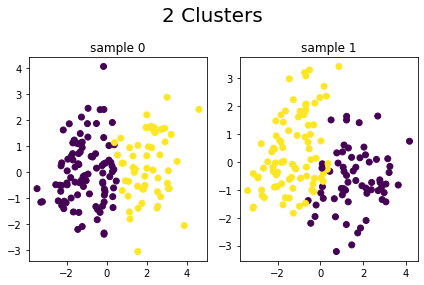

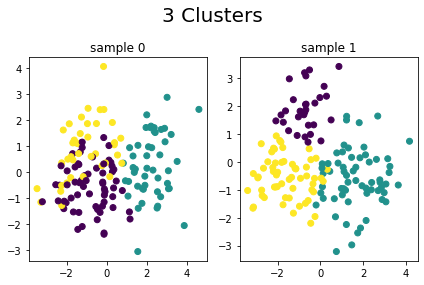

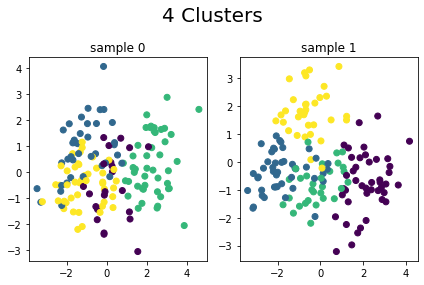

In [5]:
for cluster in range (2, 5):
    f, axarr = plt.subplots(1, 2)
    for i in range(2):
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        axarr[i].scatter(x_sub, y_sub, c = c)
        axarr[i].set_title('sample {}'.format(i))
        
    plt.suptitle('{} Clusters'.format(cluster), fontsize = 20)
    plt.tight_layout()
    plt.show()
    print('\n ')

Ignoring the specific colors assigned to each cluster, it appears that the four cluster solution doesn't seem to be consistent across the subsamples. For example, in the first subsample, k-means assigns triancle of clusters for the observations. However, in the second subsample, it assigns only three clusters for the observations that reside on the bottom of the chart. Hence, The two cluster solution seems to be the only consistent solution among all.

## Apply k-means on the whole dataset by setting k is equal two, three and four and get ARI score for each of them. Which model is the best?

In [6]:
pred_2 = KMeans(n_clusters = 2, random_state = 22).fit_predict(X_std)
pred_3 = KMeans(n_clusters = 3, random_state = 22).fit_predict(X_std)
pred_4 = KMeans(n_clusters = 4, random_state = 22).fit_predict(X_std)

print("ARI for two cluster k-means: {}".format(metrics.adjusted_rand_score(y, pred_2)))
print("ARI for three cluster k-means: {}".format(metrics.adjusted_rand_score(y, pred_3)))
print("ARI for four cluster k-means: {}".format(metrics.adjusted_rand_score(y, pred_4)))

ARI for two cluster k-means: 0.43661540614807665
ARI for three cluster k-means: 0.2752980451975643
ARI for four cluster k-means: 0.2378603215799209


According to the results, the best solution is the two cluster solution as its ARI score is the highest.

## Apply k-means on the whole dataset by setting k is equal two, three and four and get silhouette coefficient for each of them. Which model is the best?

In [7]:
print("Silhouette score for two cluster k-means: {}".format(metrics.silhouette_score(X_std, pred_2, metric = 'euclidean')))
print("Silhouette score for three cluster k-means: {}".format(metrics.silhouette_score(X_std, pred_3, metric = 'euclidean')))
print("Silhouette score for four cluster k-means: {}".format(metrics.silhouette_score(X_std, pred_4, metric = 'euclidean')))

Silhouette score for two cluster k-means: 0.17440650461256255
Silhouette score for three cluster k-means: 0.12836774655637848
Silhouette score for four cluster k-means: 0.11110070337263306


According to the results, the best solution is the two cluster solution as its silhouette score is the highest.